## 練習時間
參考 Day 12 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [1]:
# Import 需要的套件
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件

%matplotlib inline
plt.style.use('ggplot')

### 之前做過的處理

In [2]:
# 設定 data_path
dir_data = './data/'
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
# also apply to testing dataset
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# absolute the value of DAYS_BIRTH
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

## EDA: 把連續型變數離散化 -> 等頻劃分

In [3]:
# 等頻劃分
age_data = app_train[['AMT_INCOME_TOTAL', 'DAYS_BIRTH']] # subset
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365 # day-age to year-age

age_data['YEARS_BINNED'] = pd.qcut(age_data['YEARS_BIRTH'], 10)

print(age_data['YEARS_BINNED'].value_counts())
age_data.head()

(43.151, 47.178]    30764
(28.175, 32.038]    30760
(36.0, 39.496]      30759
(51.74, 56.093]     30758
(56.093, 60.77]     30757
(20.517, 28.175]    30752
(39.496, 43.151]    30745
(32.038, 36.0]      30745
(60.77, 69.121]     30738
(47.178, 51.74]     30733
Name: YEARS_BINNED, dtype: int64


/Users/alfred/anaconda3/envs/ML100-Days/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/alfred/anaconda3/envs/ML100-Days/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,AMT_INCOME_TOTAL,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,202500.0,9461,25.920548,"(20.517, 28.175]"
1,270000.0,16765,45.931507,"(43.151, 47.178]"
2,67500.0,19046,52.180822,"(51.74, 56.093]"
3,135000.0,19005,52.068493,"(51.74, 56.093]"
4,121500.0,19932,54.608219,"(51.74, 56.093]"


In [4]:
# 計算每個年齡區間的 AMT_INCOME_TOTAL、DAYS_BIRTH與 YEARS_BIRTH 的平均值
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,AMT_INCOME_TOTAL,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.517, 28.175]",155266.928742,9300.898055,25.481912
"(28.175, 32.038]",171002.089584,10998.581209,30.133099
"(32.038, 36.0]",181334.451403,12415.417108,34.014841
"(36.0, 39.496]",179388.195813,13785.630352,37.768850
"(39.496, 43.151]",181680.970226,15075.201594,41.301922
"(43.151, 47.178]",181763.084779,16462.717234,45.103335
"(47.178, 51.74]",176551.506606,18042.285394,49.430919
"(51.74, 56.093]",167904.981710,19680.460368,53.919070
"(56.093, 60.77]",156032.239007,21316.632116,58.401732


/Users/alfred/anaconda3/envs/ML100-Days/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


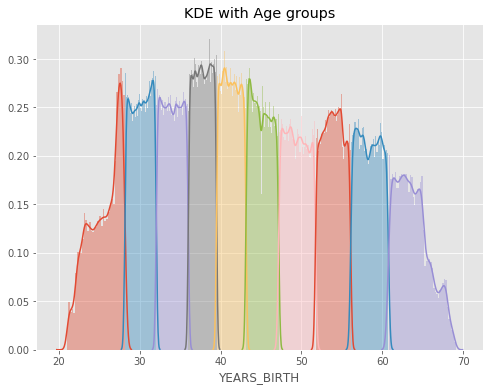

In [5]:
# visuallation
year_group_sorted = age_data['YEARS_BINNED'].unique().sort_values()

plt.figure(figsize=(8,6))
for i in range(len(year_group_sorted)):
    sns.distplot(age_data.loc[(age_data['YEARS_BINNED'] == year_group_sorted[i]), 'YEARS_BIRTH'], label = str(year_group_sorted[i]))
    
plt.title('KDE with Age groups')
plt.show()

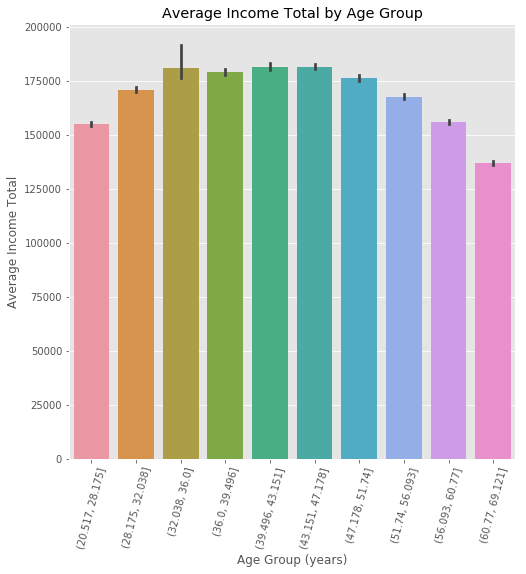

In [6]:
plt.figure(figsize = (8, 8))

# 以年齡區間為 x, target 為 y 繪製 barplot
px = 'YEARS_BINNED'
py = 'AMT_INCOME_TOTAL'
sns.barplot(px, py, data=age_data)

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Average Income Total')
plt.title('Average Income Total by Age Group');